In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

In [13]:
df=pd.read_csv('./data/data.csv', names=['index', 'title', 'genre','summary']).drop(columns='index')

In [14]:
df

,title,genre,summary
0,title,genre,summary
1,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
2,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
3,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
4,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
...,...,...,...
4653,Hounded,fantasy,"Atticus O’Sullivan, last of the Druids, lives ..."
4654,Charlie and the Chocolate Factory,fantasy,Charlie Bucket's wonderful adventure begins wh...
4655,Red Rising,fantasy,"""I live for the dream that my children will be..."
4656,Frostbite,fantasy,"Rose loves Dimitri, Dimitri might love Tasha, ..."


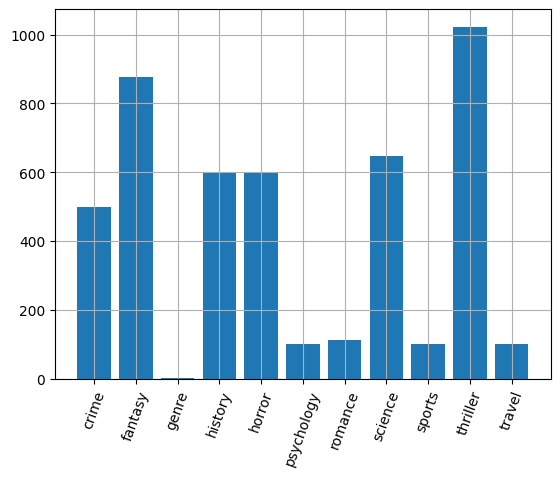

In [15]:
names,counts=np.unique(df.genre, return_counts=True)

plt.bar(np.arange(df.genre.nunique()),
        height=counts)
plt.grid()
plt.xticks(np.arange(df.genre.nunique()), names, rotation=70)
plt.show()

In [16]:
vocab=set()
max_len=0
for summary in tqdm(df.summary.map(lambda s: re.split('\W+',s.strip().lower()))):#[\n ,.;:]
    vocab=vocab.union(set(summary))
    max_len=max(max_len, len(summary))
max_len, len(vocab)

<>:3: SyntaxWarning: invalid escape sequence '\W'
<>:3: SyntaxWarning: invalid escape sequence '\W'
/tmp/ipykernel_3166/738898365.py:3: SyntaxWarning: invalid escape sequence '\W'
  for summary in tqdm(df.summary.map(lambda s: re.split('\W+',s.strip().lower()))):#[\n ,.;:]
100%|█████████████████████████████████████████████████████████| 4658/4658 [00:02<00:00, 1595.66it/s]


(5750, 55715)

# custom tokenizer

In [17]:
def get_training_corpus():
    for i in range(0, df.shape[0], 100):
        yield df.summary.values[i : i + 100]

In [18]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

In [19]:
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)

# gpt2 tokenizer

In [20]:
from transformers import GPT2Tokenizer, AutoTokenizer

In [21]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")

In [33]:
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token 
tokenized_summary=gpt2_tokenizer(df.summary.map(lambda x: x.strip().lower()).tolist(),
                    return_tensors='pt',
                    padding=True)
print(tokenized_summary['input_ids'].shape)

tokenized_title=gpt2_tokenizer(df.title.map(lambda x: x.strip().lower()).tolist(),
                    return_tensors='pt',
                    padding=True)
print(tokenized_title['input_ids'].shape)

torch.Size([4658, 7348])
torch.Size([4658, 34])


In [23]:
tokenized_summary['input_ids'].numpy().shape
tokenized_title['input_ids'].numpy().shape

(4658, 34)

In [34]:
tokenized_summary

{'input_ids': tensor([[49736, 50256, 50256,  ..., 50256, 50256, 50256],
        [   67,  2053,   276,  ..., 50256, 50256, 50256],
        [  292,   262,  1492,  ..., 50256, 50256, 50256],
        ...,
        [    1,    72,  2107,  ..., 50256, 50256, 50256],
        [13698, 10408,  5391,  ..., 50256, 50256, 50256],
        [ 1169, 19716,   286,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [35]:
tokenized_title

{'input_ids': tensor([[ 7839, 50256, 50256,  ..., 50256, 50256, 50256],
        [   67,  2053,   276,  ..., 50256, 50256, 50256],
        [ 1169,  2626,  4293,  ..., 50256, 50256, 50256],
        ...,
        [  445,  7396, 50256,  ..., 50256, 50256, 50256],
        [   69, 23341, 37018,  ..., 50256, 50256, 50256],
        [ 6335,  3610, 50256,  ..., 50256, 50256, 50256]]), 'attention_mask': tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0]])}

In [36]:
tokenized_summary['input_ids'].numpy().reshape(df.shape[0], 1, -1).shape

(4658, 1, 7348)

In [37]:
df['input_ids']=[list(x) for x in tokenized_summary['input_ids'].numpy()]
df['att_mask']=[list(x) for x in tokenized_summary['attention_mask'].numpy()]
df['title_ids'] = [list(x) for x in tokenized_title['input_ids'].numpy()]

In [38]:
genre_dict={}
for i, g in enumerate(df.genre.unique()):
    genre_dict[g]=i

In [39]:
df['label']=df.genre.map(lambda x: genre_dict[x])

In [40]:
tokens_set=set()
for tokens in df.input_ids.values:
    tokens_set=tokens_set.union(set(tokens))
for tokens in df.title_ids.values:
    tokens_set=tokens_set.union(set(tokens))
tokens_dict={}
for i, t in enumerate(tokens_set):
    tokens_dict[t]=i

In [41]:
df['mapped_inputs']=df.input_ids.map(lambda x: [tokens_dict[t] for t in x])
df['mapped_titles']=df.title_ids.map(lambda x: [tokens_dict[t] for t in x])

In [42]:
#df.drop(columns='Unnamed: 0', inplace=True)
df

,title,genre,summary,input_ids,att_mask,title_ids,label,mapped_inputs,mapped_titles
0,title,genre,summary,"[49736, 50256, 50256, 50256, 50256, 50256, 502...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[7839, 50256, 50256, 50256, 50256, 50256, 5025...",0,"[26174, 26377, 26377, 26377, 26377, 26377, 263...","[5894, 26377, 26377, 26377, 26377, 26377, 2637..."
1,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...,"[67, 2053, 276, 29445, 3462, 318, 262, 717, 36...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[67, 2053, 276, 29445, 3462, 50256, 50256, 502...",1,"[37, 1722, 165, 17907, 2821, 203, 151, 573, 21...","[37, 1722, 165, 17907, 2821, 26377, 26377, 263..."
2,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ...","[292, 262, 1492, 9808, 11, 474, 888, 3253, 316...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1169, 2626, 4293, 50256, 50256, 50256, 50256,...",1,"[181, 151, 1259, 7207, 11, 341, 732, 2671, 189...","[981, 2176, 3441, 26377, 26377, 26377, 26377, ..."
3,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...,"[66, 1018, 417, 318, 3538, 25562, 416, 262, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1169, 2951, 286, 262, 625, 6894, 50256, 50256...",1,"[36, 847, 288, 203, 2876, 16053, 287, 151, 135...","[981, 2431, 175, 151, 484, 5261, 26377, 26377,..."
4,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...,"[1169, 1492, 9808, 351, 28783, 12, 25561, 410,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[32707, 338, 6991, 50256, 50256, 50256, 50256,...",1,"[981, 1259, 7207, 232, 17595, 12, 16052, 282, ...","[19379, 221, 5325, 26377, 26377, 26377, 26377,..."
...,...,...,...,...,...,...,...,...,...
4653,Hounded,fantasy,"Atticus O’Sullivan, last of the Druids, lives ...","[1078, 24552, 267, 447, 247, 82, 16040, 11, 93...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[71, 6302, 50256, 50256, 50256, 50256, 50256, ...",1,"[900, 15557, 156, 317, 136, 52, 10978, 11, 780...","[41, 4842, 26377, 26377, 26377, 26377, 26377, ..."
4654,Charlie and the Chocolate Factory,fantasy,Charlie Bucket's wonderful adventure begins wh...,"[354, 7063, 494, 19236, 338, 7932, 8855, 6140,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[354, 7063, 494, 290, 262, 11311, 8860, 50256,...",1,"[235, 5372, 361, 12786, 221, 5953, 6562, 4724,...","[235, 5372, 361, 179, 151, 8159, 6564, 26377, ..."
4655,Red Rising,fantasy,"""I live for the dream that my children will be...","[1, 72, 2107, 329, 262, 4320, 326, 616, 1751, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[445, 7396, 50256, 50256, 50256, 50256, 50256,...",1,"[1, 42, 1767, 213, 151, 3461, 211, 475, 1482, ...","[315, 5595, 26377, 26377, 26377, 26377, 26377,..."
4656,Frostbite,fantasy,"Rose loves Dimitri, Dimitri might love Tasha, ...","[13698, 10408, 5391, 49510, 11, 5391, 49510, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[69, 23341, 37018, 50256, 50256, 50256, 50256,...",1,"[9635, 7591, 4236, 26093, 11, 4236, 26093, 105...","[39, 14943, 21227, 26377, 26377, 26377, 26377,..."


In [43]:
df.to_parquet('./data/books.par')